# Reduced Gravity

## Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

from importlib import reload

GPU Ocean-modules:

In [2]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, NetCDFInitialization, OceanographicUtilities, Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [3]:
%cuda_context_handler baroclinic_gpu_ctx

In [4]:
%cuda_context_handler barotropic_gpu_ctx

#### Plotting utils

In [5]:
from IPython.display import clear_output
from matplotlib import animation, rc
plt.rcParams["animation.html"] = "jshtml"
from gpuocean.utils import PlotHelper
from gpuocean.utils.NetCDFInitialization import depth_integration

def plotSolution(fig, 
                 eta, hu, hv, h, dx, dy, 
                 t, comment,
                 h_min=-5, h_max=5, 
                 uv_min=-0.3, uv_max=0.3,
                 calc_uv = False, 
                 add_extra=False,
                 reduced_gravity_interface=None,
                 ax=None, sp=None):


    from datetime import timedelta
    fig.suptitle("Time = {:0>8} ({:s})".format(str(timedelta(seconds=int(t))), comment), 
                 fontsize=18,
                 horizontalalignment='left')
    
    ny, nx = eta.shape
    domain_extent = [0, nx*dx, 0, ny*dy]
    
    x_plots = 3
    y_plots = 1
    if (add_extra == True):
        x_plots=3
        y_plots=2
    
    V_max = 3 * (uv_max-uv_min) / np.max(h)
    R_min = -V_max/2000
    R_max = V_max/2000
   
    hu_label, hv_label = "$hu$", "$hv$"
    if calc_uv:
        """plotting actually u and v"""
        if reduced_gravity_interface is None or reduced_gravity_interface == 0.0:
            hu = hu/(h+eta)
            hv = hv/(h+eta)
        else:
            hu = hu/(reduced_gravity_interface+eta)
            hv = hv/(reduced_gravity_interface+eta)
        uv_min = -0.3
        uv_max = +0.3
        hu_label, hv_label = "$u$", "$v$"

    if (ax is None):
        ax = [None]*x_plots*y_plots
        sp = [None]*x_plots*y_plots
        
        ax[0] = plt.subplot(y_plots, x_plots, 1)
        sp[0] = ax[0].imshow(eta, interpolation="none", origin='lower', 
                             cmap=plt.cm.coolwarm, 
                             vmin=h_min, vmax=h_max, 
                             extent=domain_extent)
        plt.colorbar(sp[0], shrink=0.9)
        plt.axis('image')
        plt.title("$\eta{}$")
        
  

        ax[1] = plt.subplot(y_plots, x_plots, 2)
        sp[1] = ax[1].imshow(hu, interpolation="none", origin='lower', 
                            cmap=plt.cm.coolwarm, 
                            vmin=uv_min, vmax=uv_max, 
                            extent=domain_extent)
        plt.colorbar(sp[1], shrink=0.9)
        plt.axis('image')
        plt.title(hu_label)



        ax[2] = plt.subplot(y_plots, x_plots, 3)
        sp[2] = ax[2].imshow(hv, interpolation="none", origin='lower', 
                             cmap=plt.cm.coolwarm, 
                             vmin=uv_min, vmax=uv_max, 
                             extent=domain_extent)
        plt.colorbar(sp[2], shrink=0.9)
        plt.axis('image')
        plt.title(hv_label)
            
    else:        
        #Update plots
        fig.sca(ax[0])
        sp[0].set_data(eta)
        
        fig.sca(ax[1])
        sp[1].set_data(hu)
        
        fig.sca(ax[2])
        sp[2].set_data(hv)
        
        if (add_extra == True):
            V = PlotHelper.genVelocity(h, hu, hv)
            fig.sca(ax[3])
            sp[3].set_data(V)

            R = PlotHelper.genColors(h, hu/dx, hv/dy, plt.cm.seismic, R_min, R_max)
            fig.sca(ax[4])
            sp[4].set_data(R)
    
    return ax, sp


def ncAnimation(filename, movie_frames=None, create_movie=True, fig=None, x0=0, x1=-1, y0=0, y1=-1, reduced_gravity_interface=None, **kwargs):
    #Create figure and plot initial conditions
    if fig is None:
        fig = plt.figure(figsize=(14, 4))

    try:
        if isinstance(filename, list):
            # Only for own nc-files
            ncfile = Dataset(filename[0])
            x = ncfile.variables['x'][:]
            y = ncfile.variables['y'][:]
            t = ncfile.variables['time'][:]
            H_m = ncfile.variables['Hm'][:,:]
            eta = ncfile.variables['eta'][:,:,:]
            hu = ncfile.variables['hu'][:,:,:]
            hu = hu/H_m # actually u
            hv = ncfile.variables['hv'][:,:,:]
            hv = hv/H_m # actually u  
            calc_uv = False
            for f in range(1,len(filename)):
                ncfile = Dataset(filename[f])
                eta += ncfile.variables['eta'][:,:,:]
                hu += ncfile.variables['hu'][:,:,:]/(ncfile.variables['Hm'][:,:] + ncfile.variables['eta'][:,:,:])
                hv += ncfile.variables['hv'][:,:,:]/(ncfile.variables['Hm'][:,:] + ncfile.variables['eta'][:,:,:])
            filename = "Combined Variables"
        else:
            ncfile = Dataset(filename)
            try:
                x = ncfile.variables['x'][:]
            except:
                x = ncfile.variables['X'][x0:x1]
            try:
                y = ncfile.variables['y'][:]
            except:
                y = ncfile.variables['Y'][y0:y1]
            t = ncfile.variables['time'][:]

            try:
                H_m = ncfile.variables['Hm'][:,:]
            except:
                H_m = ncfile.variables['h'][y0:y1,x0:x1]
            try:
                eta = ncfile.variables['eta'][:,:,:]
            except:
                eta = ncfile.variables['zeta'][:,y0:y1,x0:x1]
            try:
                hu = ncfile.variables['hu'][:,:,:]
                calc_uv = True
            except:
                if reduced_gravity_interface is None:
                    hu = ncfile.variables['ubar'][:,y0:y1,x0:x1]
                    calc_uv = False
                else:
                    if reduced_gravity_interface is not None:
                        hu = np.ma.zeros(eta.shape)
                        for t_idx in range(len(t)):
                            hu[t_idx] = depth_integration(ncfile, reduced_gravity_interface, x0, x1, y0, y1, "u", timestep_index=t_idx)
                        calc_uv = True
                    else:
                        hu = ncfile.variables['u'][:,0,y0:y1,x0:x1]
                        calc_uv = False
            try:
                hv = ncfile.variables['hv'][:,:,:]
            except:
                if reduced_gravity_interface is None:
                    hv = ncfile.variables['vbar'][:,y0:y1,x0:x1]
                else:
                    if reduced_gravity_interface is not None:
                        hv = np.ma.zeros(eta.shape)
                        for t_idx in range(len(t)):
                            hv[t_idx] = depth_integration(ncfile, reduced_gravity_interface, x0, x1, y0, y1, "v", timestep_index=t_idx)
                    else:
                        hv = ncfile.variables['v'][:,0,y0:y1,x0:x1]
                    
    except Exception as e:
        raise e
    finally:
        ncfile.close()


    if movie_frames is None:
        movie_frames = len(t)

    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    progress = Common.ProgressPrinter(5)

    if (create_movie):
        ax, sp = plotSolution(fig, 
                              eta[0],
                              hu[0],
                              hv[0],
                              H_m+eta[0],
                              dx, dy, 
                              t[0], filename,
                              calc_uv=calc_uv,
                              reduced_gravity_interface=reduced_gravity_interface,
                              **kwargs)
    else:
        ax, sp = plotSolution(fig, 
                              eta[-1],
                              hu[-1],
                              hv[-1],
                              H_m+eta[-1],
                              dx, dy, 
                              t[-1], filename,
                              **kwargs)
        return

    #Helper function which simulates and plots the solution    
    def animate(i):
        t_now = t[0] + (i / (movie_frames-1)) * (t[-1] - t[0]) 

        k = np.searchsorted(t, t_now)
        if (k >= eta.shape[0]):
            k = eta.shape[0] - 1
        j = max(0, k-1)
        if (j == k):
            k += 1
        s = (t_now - t[j]) / (t[k] - t[j])

        plotSolution(fig, 
                        (1-s)*eta[j] + s*eta[k], 
                        (1-s)*hu[j]  + s*hu[k], 
                        (1-s)*hv[j]  + s*hv[k], 
                        H_m+(1-s)*eta[j] + s*eta[k], 
                        dx, dy, 
                        t_now, filename,
                        calc_uv=calc_uv,
                        reduced_gravity_interface=reduced_gravity_interface,
                        **kwargs, ax=ax, sp=sp)

        clear_output(wait = True)
        #print(progress.getPrintString(i / (movie_frames-1)))

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(movie_frames), interval=250)
    plt.close(fig)
    
    return anim


## Selecting area and loading initial- and boundary conditions

In [6]:
source_url_list = ['https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc']#,'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071700.nc','https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071800.nc']

casename = 'lofoten'

case_info = NetCDFInitialization.getCaseLocation(casename)
case_info.pop("name")

'lofoten'

In [7]:
from gpuocean.utils import NetCDFInitialization
reload(NetCDFInitialization)

barotropic_data_args, baroclinic_data_args = NetCDFInitialization.getCombinedInitialConditions(source_url_list,case_info["x0"], case_info["x1"], case_info["y0"], case_info["y1"], 25.0, download_data=False)

Cut the bathymetry: no reconstruction!
Depth integration with trapeziodal rule, ignoring eta
Reduce gravity (fixed value used)
Depth integration with trapeziodal rule, ignoring eta
This download maybe avoided by interpolation (and using the right mask)


In [8]:
barotropic_data_args.pop("wind_stress", None)

### Make sims

In [9]:
from importlib import reload
from gpuocean.SWEsimulators import CombinedCDKLM16
reload(CombinedCDKLM16)

<module 'gpuocean.SWEsimulators.CombinedCDKLM16' from '/home/florianb/havvarsel/gpuocean/src/gpuocean/SWEsimulators/CombinedCDKLM16.py'>

In [10]:
sim_flags={"barotropic":True, "baroclinic":True}

In [11]:
sims = CombinedCDKLM16.CombinedCDKLM16(baroclinic_gpu_ctx, barotropic_gpu_ctx, dt=0.0, sim_flags=sim_flags, write_netcdf=True, **NetCDFInitialization.removeCombinedMetadata(barotropic_data_args, baroclinic_data_args))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


### Make drifters

In [12]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': sims.nx, 'ny': sims.ny,
                'domain_size_x': sims.nx*sims.dx,
                'domain_size_y': sims.ny*sims.dy,
                'land_mask': sims.getLandMask()
                }

trajectories = Observation.Observation(**observation_args)

baroclinic_trajectories = Observation.Observation(**observation_args)
barotropic_trajectories = Observation.Observation(**observation_args)

In [13]:
initx = [200000, 175000]
inity = [175000, 175000]

In [14]:
num_drifters = len(initx)

drifters = GPUDrifterCollection.GPUDrifterCollection(sims.barotropic_gpu_ctx, num_drifters,
                                                    boundaryConditions = sims.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = sims.gpu_stream)

drifter_pos_init = np.array([initx, inity]).T
drifters.setDrifterPositions(drifter_pos_init)

In [15]:
barotropic_drifters = GPUDrifterCollection.GPUDrifterCollection(sims.barotropic_gpu_ctx, num_drifters,
                                                    boundaryConditions = sims.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = sims.gpu_stream)
barotropic_drifters.setDrifterPositions(drifter_pos_init)

baroclinic_drifters = GPUDrifterCollection.GPUDrifterCollection(sims.baroclinic_gpu_ctx, num_drifters,
                                                    boundaryConditions = sims.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = sims.gpu_stream)
baroclinic_drifters.setDrifterPositions(drifter_pos_init)

In [16]:
sims.attachDrifters(drifters, baroclinic_drifters, barotropic_drifters)
trajectories.add_observation_from_sim(sims)

### Simulation

In [17]:
for hour in range(24):
    sims.combinedStep(3600.0, trajectory_dt=60, trajectories=trajectories, baroclinic_trajectories=baroclinic_trajectories, barotropic_trajectories=barotropic_trajectories)

## Baroclinic Simulation

In [18]:
#anim = ncAnimation(sims.baroclinic_sim.sim_writer.output_file_name)

In [19]:
#anim

## Barotropic Simulation

In [20]:
#anim = ncAnimation(sims.barotropic_sim.sim_writer.output_file_name)

In [21]:
#anim

## Combining baroclinic and barotropic solutions
- $\eta_0 + \eta_1$
- $u_0 + u_1$
- $v_0 + v_1$

In [22]:
#anim = ncAnimation([sims.barotropic_sim.sim_writer.output_file_name, sims.baroclinic_sim.sim_writer.output_file_name])

In [23]:
#anim

### Opendrift 

In [27]:
from gpuocean.utils.GPUOcean_runDeterministic import * 

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.utilsOpenDrift import *

In [28]:
lon, lat = xygpuocean2lonlat(source_url_list[0], initx, inity, case_info["x0"], case_info["y0"])
oceandrift = simulate_opendrift(source_url_list[0], lat= lat, lon= lon, velocity_average=False) #no wind
opendrift_trajectories = opendriftObj2gpuoceanObs(oceandrift, case_info["x0"], case_info["x1"], case_info["y0"], case_info["y1"], source_url_list[0])

## Drift Trajectory Results

In [50]:
def plot_all_drifters(sims, trajectories, barotropic_trajectories, opendrift_trajectories):

    drifter_ids = np.arange(trajectories.get_num_drifters(ignoreBuoys=True))

    num_drifters = len(drifter_ids)

    drifter_paths = [None]*num_drifters
    barotropic_drifter_paths = [None]*num_drifters
    opendrift_drifter_paths = [None]*num_drifters

    forecast_start_t = 0
    forecast_end_t = sims.t

    for i in range(num_drifters):
        drifter_paths[i] = trajectories.get_drifter_path(drifter_ids[i], forecast_start_t, forecast_end_t, in_km = False)
        barotropic_drifter_paths[i] = barotropic_trajectories.get_drifter_path(drifter_ids[i], forecast_start_t, forecast_end_t, in_km = False)
        opendrift_drifter_paths[i] = opendrift_trajectories.get_drifter_path(drifter_ids[i], forecast_start_t, forecast_end_t, in_km = False)

    rows = np.int(np.floor(num_drifters/4)) + 1 
    fig, axs = plt.subplots(rows,4, figsize=(16,4*rows))

    for p in range(num_drifters):
        plot_background(axs[p], sims)
        plot_one_drifter(axs[p], drifter_paths[p], label="combined")
        plot_one_drifter(axs[p], barotropic_drifter_paths[p], label="barotropic", ls=":")
        plot_one_drifter(axs[p], opendrift_drifter_paths[p], label="opendrift", c="green")   
        axs[p].legend(labelcolor="black")     


def plot_background(ax, sims):
    
    combined_eta, combined_u, combined_v = sims.download() 
    uv_field = np.sqrt(combined_u**2 + combined_v**2)


    domain_extent = [0, sims.nx*sims.dx, 0, sims.ny*sims.dy]

    ax.imshow(uv_field, interpolation="none", origin='lower', 
                    cmap=plt.cm.Reds, 
                    vmin=0.0, vmax=0.5, 
                    extent=domain_extent)


def plot_one_drifter(ax, drifter_path, label=None, c="blue", ls="-"):

    for path in drifter_path:

        ax.plot(path[:,0], path[:,1], color=c, ls=ls, zorder=5, label=label)

        # Mark start and end of true path
        start_pos = drifter_path[0][0,:]
        end_pos   = drifter_path[-1][-1,:]

        circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                20, color = 'xkcd:scarlet',
                                                fill=False, zorder=10)
        ax.add_patch(circ_start)
        ax.plot(end_pos[0], end_pos[1], 'x', color='k', zorder=11)

        ax.set_xlim(start_pos[0] + np.array([-12500,12500]))
        ax.set_ylim(start_pos[1] + np.array([-12500,12500]))


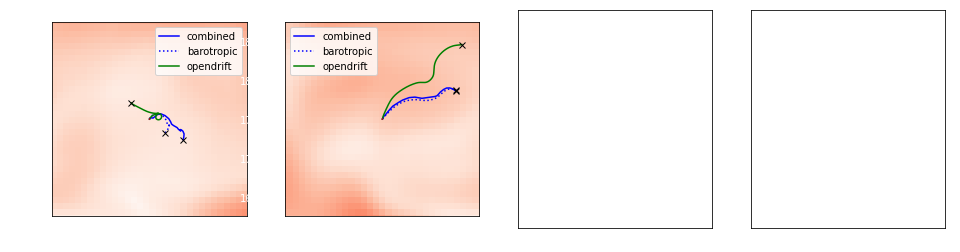

In [51]:
plot_all_drifters(sims, trajectories, barotropic_trajectories, opendrift_trajectories)